# Cascaded tanks experiment
This experiments requires external data.  Make sure the folder ```/data/cascaded_tanks``` contains the file ```dataBenchmark.mat``` from [Schoukens et al.](https://data.4tu.nl/articles/_/12960104)

In [1]:
import sys; sys.path.append('../..')   # Allow relative imports from the parent folder

import numpy as np
from scipy.io import loadmat

from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

import jax 
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jr

import optax

import equinox as eqx

from dynax import training
from dynax import evaluation
from dynax.function_models import LyapunovNN, OnsagerNetPotential, FICNN, \
                                  SymplecticMatrix, \
                                  ConstantMatrix, ConstantSPDMatrix, \
                                  MLP
from dynax.integration_models import ODESolver
from dynax.derivative_models import BaseModel, ISPHS
from dynax.losses import mse
from dynax.sphnn_tools import is_zero_gas_guarantee_valid
from dynax.data_handling import Normalizer, NormalizationWrapper

from pathlib import Path
import json

from functools import partial

from util import colors
from util.model_meta import model_style, model_names

ACTIVATIONS = dict(
    softplus = jax.nn.softplus,
    tanh = jax.nn.tanh,
    relu = jax.nn.relu,
)

INITIALIZERS = dict(
    he_uniform = jax.nn.initializers.he_uniform(),
    glorot_uniform = jax.nn.initializers.glorot_uniform(),
    zeros = jax.nn.initializers.zeros,
)

### Matplotlib Settings 
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors.set_custom_cycle()

PLOT_DPI = 200

## Model and training definitions

In [2]:
def define_sPHNN_model(model_hyperparams: dict,
                       *, key):

    r_key, g_key, h_key= jr.split(key, 3)

    state_size, input_size = 2, 1

    J = SymplecticMatrix(state_size)    # (It does not make any sense for a 2d system to make the poisson matrix constant, but learnable.)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    ficnn = FICNN(state_size, 'scalar', 
                  width=model_hyperparams['ficnn_width'],
                  depth=model_hyperparams['ficnn_depth'],
                  activation=jnn.softplus,
                  w_initializer=model_hyperparams['weight_initialization'], 
                  b_initializer=model_hyperparams['bias_initialization'], 
                  key=h_key)
    H = LyapunovNN(ficnn, minimum=jnp.zeros(state_size))
    sphnn_ = ISPHS(H, J, R, g)
    sphnn_ode = ODESolver(sphnn_, augmentation=1, augmentation_learnable=True)

    return sphnn_ode

def define_sPHNN_LM_model(model_hyperparams: dict,
                          *, key):
    
    r_key, g_key, h_key= jr.split(key, 3)

    state_size, input_size = 2, 1

    J = SymplecticMatrix(state_size)    # (It does not make any sense for a 2d system to make the poisson matrix constant, but learnable.)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    ficnn_key, minimum_key = jr.split(h_key, 2)
    ficnn = FICNN(state_size, 'scalar', 
                  width=model_hyperparams['ficnn_width'],
                  depth=model_hyperparams['ficnn_depth'],
                  activation=jnn.softplus,
                  w_initializer=model_hyperparams['weight_initialization'], 
                  b_initializer=model_hyperparams['bias_initialization'], 
                  key=ficnn_key)
    H = LyapunovNN(ficnn, initialize_minimum='random', key=minimum_key) 
    sphnn_lm = ISPHS(H, J, R, g)
    sphnn_lm_ode = ODESolver(sphnn_lm, augmentation=1, augmentation_learnable=True) 

    return sphnn_lm_ode

def define_PHNN_model(model_hyperparams: dict,
                      *, key):

    r_key, g_key, h_key= jr.split(key, 3)

    state_size, input_size = 2, 1

    J = SymplecticMatrix(state_size)    # (It does not make any sense for a 2d system to make the poisson matrix constant, but learnable.)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    H = MLP(in_size=state_size, out_size='scalar', 
            width_size=model_hyperparams['mlp_width'],
            depth=model_hyperparams['mlp_depth'],
            weight_initializer=model_hyperparams['weight_initialization'],
            bias_initializer=model_hyperparams['bias_initialization'],  
            activation=model_hyperparams['activation'], 
            key=h_key)
    phnn_ = ISPHS(H, J, R, g)
    phnn_ode_ = ODESolver(phnn_, augmentation=1, augmentation_learnable=True)

    return phnn_ode_

def define_NODE_model(model_hyperparams: dict,
                       *, key):
    
    mlp = MLP(3, 2, 
              width_size=model_hyperparams['mlp_width'],
              depth=model_hyperparams['mlp_depth'],
              weight_initializer=model_hyperparams['weight_initialization'],
              bias_initializer=model_hyperparams['bias_initialization'],  
              activation=model_hyperparams['activation'],
              key=key)
    div_model = BaseModel(mlp, 2, 1)
    node = ODESolver(div_model, augmentation=1, augmentation_learnable=True,
                     max_steps=8192,
                     )

    return node

def define_cPHNN_model(model_hyperparams: dict,
                      *, key):

    r_key, g_key, h_key= jr.split(key, 3)

    state_size, input_size = 2, 1

    J = SymplecticMatrix(state_size)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)
    g = ConstantMatrix((state_size, input_size), initialize=jnn.initializers.zeros, key=g_key)

    H = OnsagerNetPotential(
        state_size, 
        width_size=model_hyperparams['mlp_width'],
        depth=model_hyperparams['mlp_depth'],
        activation=model_hyperparams['activation'],
        weight_initializer=model_hyperparams['weight_initialization'],
        bias_initializer=model_hyperparams['bias_initialization'],  
        beta=model_hyperparams['beta'], 
        beta_learnable=model_hyperparams['beta_learnable'], 
        key=h_key
    )
    cphnn_ = ISPHS(H, J, R, g)
    cphnn_ode_ = ODESolver(cphnn_, augmentation=1, augmentation_learnable=True, max_steps=2**18)

    return cphnn_ode_


def get_rmse(model, ts, ys, us):
    ys_pred = jax.vmap(model, in_axes=(None, 0, 0))(ts, ys[:,0], us)
    return jnp.sqrt(jnp.mean(jnp.square(ys_pred - ys)))

def train_template(model, 
                   training_data: tuple, validation_data: tuple|None,
                   training_hyperparams: dict,
                   weights_dir=None, overwrite=False,
                   loss_fn = mse,
                   *, key):

    try:
        model = training.load_weights(weights_dir/Path('weights.eqx'), model)
        history = training.load_history(weights_dir/Path('history.npz'))

    except FileNotFoundError:
        model, history = training.fit_trajectory(
            model, *training_data,
            validation_data = validation_data,
            loss_fn         = loss_fn,
            batch_size      = training_hyperparams['batch_size'],
            steps           = training_hyperparams['steps'],
            optimizer       = optax.adam(training_hyperparams['learning_rate']),
            log_loss_every  = 100,
            key             = key
            )
        
        training.save_weights(weights_dir/Path('weights'), model, overwrite)
        training.save_history(weights_dir/Path('history'), history, overwrite)

    return model, history

def evaluation_template(model, 
                        training_data: tuple, test_data: tuple,
                        metrics_dir: Path):
    
    # Load RMSE data if available, otherwise compute it
    try:
        error_measures = np.load(metrics_dir/Path('error_measures.npz'))
        error_measures = dict(error_measures)
    except FileNotFoundError:
        error_measures = {
            'test_rmse': get_rmse(model, *test_data),
            'train_rmse': get_rmse(model, *training_data),
        }
        np.savez(metrics_dir/Path('error_measures.npz'), **error_measures)

    return error_measures


def get_hyperparams(file: Path, default_hyperparamse: dict):
    file = Path(file)
    try:
        with open(file, 'r') as f:
            hyperparams = json.load(f)

        print('Loaded hyperparameters from JSON file.')
        return hyperparams

    except FileNotFoundError:
        file.parent.mkdir(parents=True, exist_ok=True)
        with open(file, 'w') as f:
            json.dump(default_hyperparamse, f, indent=4)
        print('No JSON file found. Saving specified hyperparameters.')
        return default_hyperparamse

## Load the data
Make sure the folder ```/data/cascaded_tanks``` contains the file ```dataBenchmark.mat``` from Schoukens et al. ([Dataset](https://data.4tu.nl/articles/_/12960104))

In [3]:
data_dir = Path(R'..\..\data')

file = data_dir/R'cascaded_tanks\dataBenchmark.mat'
data = loadmat(file)

ys_train = jnp.expand_dims(jnp.stack(data['yEst'], axis=0), axis=0)
us_train = jnp.expand_dims(jnp.stack(data['uEst'], axis=0), axis=0)
ts = 4.0*jnp.arange(ys_train.shape[1])

ys_vali = jnp.expand_dims(jnp.stack(data['yVal'], axis=0), axis=0)
us_vali = jnp.expand_dims(jnp.stack(data['uVal'], axis=0), axis=0)

# Create training and test split
validation_data = ((ts, ys_vali[:,0], us_vali), ys_vali)
training_data = (ts, ys_train, us_train)
test_data     = (ts, ys_vali, us_vali)

# Normalize the data
ys_shift = 0.
ys_scale = jnp.std(ys_train - ys_shift)
y_normalizer = Normalizer(ys_shift, ys_scale)

us_shift = 0.
us_scale = jnp.std(us_train - us_shift)
u_normalizer = Normalizer(us_shift, us_scale)

# Approximately rescale time such that the standard deviation of all (finite difference) derivatives are 1
ts_shift = 0.
ts_scale = ys_scale / jnp.std(jnp.diff(ys_train, axis=1) / jnp.diff(ts)[None,:,None])   
t_normalizer = Normalizer(ts_shift, ts_scale)

# Compute the normalized data
def get_normalized(ts, ys, us):
    ts_norm  = t_normalizer.normalize(ts)
    ys_norm  = y_normalizer.normalize(ys)
    us_norm  = u_normalizer.normalize(us)
    return ts_norm, ys_norm, us_norm

train_data_norm = get_normalized(ts, ys_train, us_train)
ts_vali_norm, ys_vali_norm, us_vali_norm  = get_normalized(ts,  ys_vali,  us_vali )
vali_data_norm = ((ts_vali_norm, ys_vali_norm[:,0], us_vali_norm), ys_vali_norm)

# Function to wrap trained models
def attach_normalizer(model: eqx.Module):
    return NormalizationWrapper(model, t_normalizer, y_normalizer, u_normalizer)

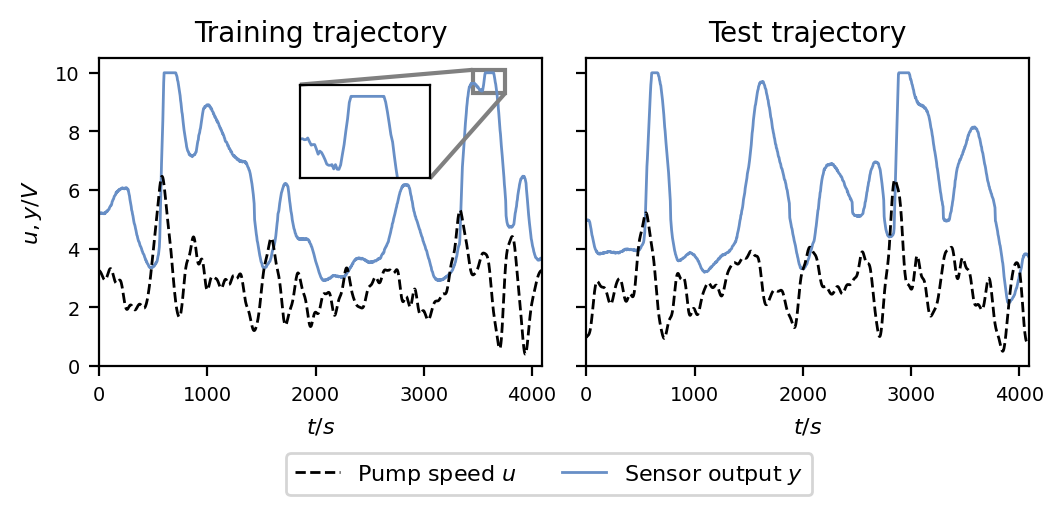

In [4]:
plot_kwargs = {'lw': 1}
y_kwargs = dict(
    color = colors.theme_colors['lightblue'],
    label = 'Sensor output $y$',
) | plot_kwargs
u_kwargs = dict(
    color = colors.theme_colors['black'],
    label = 'Pump speed $u$',
    ls = '--',
) | plot_kwargs
axis_kwargs = dict(
    xlabel = '$t / s$', 
    xlim = [ts.min(), ts.max()],
    ylim = [0,10.5],
)

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=PLOT_DPI, sharey='row', 
                         gridspec_kw={'wspace': 0.1},)

y_line, = axes[0].plot(ts, ys_train[0,:,0].T, **y_kwargs)
u_line, = axes[0].plot(ts, us_train[0,:,0].T, **u_kwargs)
axes[0].set(
    title = 'Training trajectory',
    ylabel = '$u, y / V$',
    **axis_kwargs,
)
axes[1].plot(ts, ys_vali[0,:,0].T, **y_kwargs)
axes[1].plot(ts, us_vali[0,:,0].T, **u_kwargs)
axes[1].set(title = 'Test trajectory', **axis_kwargs)

## Plot zoomed in area
axins = zoomed_inset_axes(axes[0], zoom=4, 
                          loc='upper center', bbox_to_anchor=(0.6, 0.95), bbox_transform=axes[0].transAxes)
axins.plot(ts, ys_train[0,:,0].T, **y_kwargs)
axins.set(
    xlim=[3450, 3750], ylim=[9.3,10.1],
    xticks=[], yticks=[],
    )
mark_inset(axes[0], axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1.5)

fig.patch.set_alpha(0.)     # Transparent background
plt.legend(handles=[u_line, y_line],
           loc='upper center', bbox_to_anchor=(0.5, -0.08), 
           bbox_transform=fig.transFigure, fancybox=True, shadow=False, ncol=2)
plt.show()

## Set Hyperparameters
The following sets the hyperparameters for the experiment and/or the directory to save/load the trained models to.

In [5]:
# Directory of the files for saving or loading
save_dir = Path(R'results/run_0')

default_hyperparams = {
    'meta': dict(
        description = 'Reproducing results.',
        num_instances = 20,
    ),
    'sPHNN': dict(
        ficnn_width             = 16,
        ficnn_depth             = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
    ),
    'sPHNN-LM': dict(
        ficnn_width             = 16,
        ficnn_depth             = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
    ),
    'PHNN': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus'
    ),
    'NODE': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'tanh'
    ),
    'cPHNN': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus',
        beta                    = 0.1,
        beta_learnable          = False,
    ),
    'training': dict(
        batch_size      = 5,
        steps           = 50000,
        learning_rate   = 5e-4,
    ),
}

# Load hyperparameters / Save hyperparameters if new experiment
hyperparams = get_hyperparams(save_dir/'hyperparameters.json', default_hyperparams)

# Substitute the activations and intialization schemes
for model in hyperparams.values():
    if 'activation' in model.keys():
        model['activation'] = ACTIVATIONS[model['activation']]
    if 'weight_initialization' in model.keys():
        model['weight_initialization'] = INITIALIZERS[model['weight_initialization']]
    if 'bias_initialization' in model.keys():
        model['bias_initialization'] = INITIALIZERS[model['bias_initialization']]


Loaded hyperparameters from JSON file.


## Train (or load) models


In [6]:
# Complete model definitions to include data specific information and collect the functions in a dict
model_definitions = {
    'sPHNN':    partial(define_sPHNN_model, 
                        model_hyperparams      = hyperparams['sPHNN']),
    'sPHNN-LM': partial(define_sPHNN_LM_model, 
                        model_hyperparams      = hyperparams['sPHNN-LM']),
    'cPHNN':    partial(define_cPHNN_model,
                        model_hyperparams      = hyperparams['cPHNN']),
    'PHNN':     partial(define_PHNN_model,
                        model_hyperparams      = hyperparams['PHNN']),
    'NODE':     partial(define_NODE_model,
                        model_hyperparams      = hyperparams['NODE']),
}

# Load/Train the models
num_instances = hyperparams['meta']['num_instances']
results = {}
for model_name, definition in model_definitions.items():
    print(f'{model_name:-^40}')


    # Complete training definition
    train_model = partial(train_template,
                          training_data = train_data_norm if model_name == 'cPHNN' else training_data,
                          validation_data = vali_data_norm if model_name == 'cPHNN' else validation_data,
                          training_hyperparams = hyperparams['training'],
                          loss_fn = mse)

    evaluate_model = partial(evaluation_template,
                             training_data = training_data,
                             test_data = test_data)


    def train_instance(instance_id: int):
        key = jr.key(instance_id)
        model_key, loader_key = jr.split(key, 2)

        # Define the model
        _model = definition(key=model_key)

        # Train or load the model
        weights_dir=save_dir/model_name/f'instance_{instance_id}'
        _model, history = train_model(_model,
                                    weights_dir=weights_dir,
                                    key=loader_key)
        model = training.resolve_constraints(_model)

        # Attach normalization wrapper to be able to call the model with non-normalized data
        if model_name == 'cPHNN':
            model = attach_normalizer(model)

        # Evaluate the model
        error_measures = evaluate_model(model, 
                                        metrics_dir=weights_dir)

        instance_result = dict(
            model = model,
            history = history,
        ) | error_measures

        return instance_result
    
    results[model_name] = []
    for i in range(num_instances):
        results[model_name].append(train_instance(i))

-----------------sPHNN------------------
----------------sPHNN-LM----------------
-----------------cPHNN------------------
------------------PHNN------------------
------------------NODE------------------


#### Check if all sPHNNs are 0-GAS (Globally asymptotically stable)

In [7]:
for model_name in ['sPHNN', 'sPHNN-LM']:
    all_passed = True
    for n, instance_result in enumerate(results[model_name]):
        isphs = instance_result['model'].derivative_model
        if not is_zero_gas_guarantee_valid(isphs, 1e-4):
            all_passed = False
            print(f'{model_name} instance {n} might not be 0-GAS.')
    if all_passed:
        print(f'All {model_name} instances are 0-GAS')

All sPHNN instances are 0-GAS
All sPHNN-LM instances are 0-GAS


## Evaluation
#### Box/Violinplot

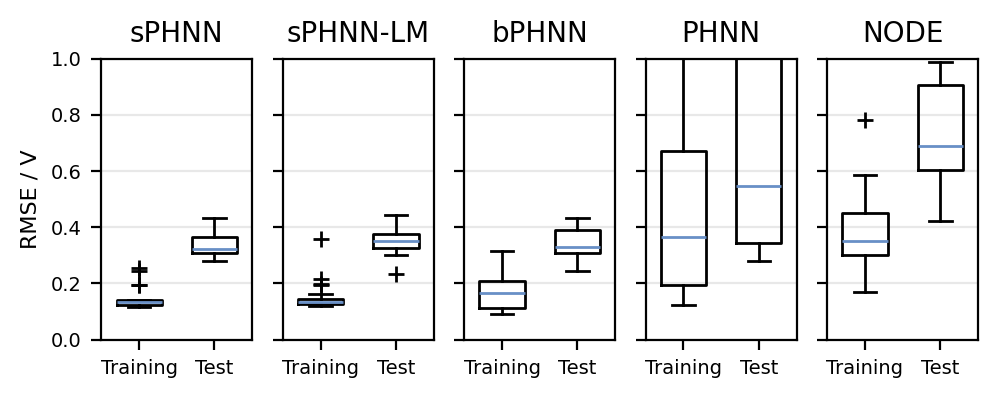

In [8]:
violinplot = False      # True -> Violinplot, False > Boxplot
use_models = ['sPHNN', 'sPHNN-LM', 'cPHNN', 'PHNN', 'NODE']
colorful = False        # If true, then the median lines are drawn in the model color

plot_rmse_data = {}
for model_type, instances in results.items():
    if model_type not in use_models:
        continue
    plot_rmse_data[model_type] = {
        'training': [inst['train_rmse'] for inst in instances],
        'test':     [inst['test_rmse'] for inst in instances],
    }

n_results = len(plot_rmse_data)
fig, axes = plt.subplots(1, n_results, figsize=(n_results, 2), dpi=PLOT_DPI, sharey=True)
axes = np.atleast_1d(axes)
for n, (ax, (model_type, rmses)) in enumerate(zip(axes, plot_rmse_data.items())):

    if violinplot:
        vp = ax.violinplot(rmses.values(), showextrema=True, showmeans=False, showmedians=True)
        plt.setp(vp['cmedians'], color='red')
    else:
        bp = ax.boxplot(rmses.values(), notch=False, sym='+', vert=True, widths=(0.6, 0.6))
        plt.setp(bp['medians'], color=model_style[model_type]['c'] if colorful else colors.theme_colors['lightblue'])

    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

    ax.set(
        axisbelow=True,
        title=model_names[model_type],
        ylabel=R'RMSE / V' if n==0 else '',
        xticks=[1,2],
        xticklabels=['Training', 'Test'],
        ylim=[0, 1],
    )

fig.tight_layout()
name_add_on = 'violinplot' if violinplot else 'boxplot'
plt.show()

#### Relaxation experiment

In [9]:
ts_eval, ys_eval, us_eval = test_data 

n_extra = 200
ts_extra = jnp.concat([ts_eval, 4*(1+jnp.arange(n_extra)) + ts_eval[-1]])
#                               4 is from 4s sample interval
ys_extra = jnp.concat([ys_eval, jnp.full((1,n_extra,1), jnp.nan)], axis=1)
us_extra = jnp.concat([us_eval, jnp.zeros((1,n_extra,1))], axis=1)

prediction_data, true_data = evaluation.get_prediction_statistics(ts_extra, ys_extra, us_extra, results, exclude_model_types='physical')

# of valid sPHNN predictions: 20
# of valid sPHNN-LM predictions: 20
# of valid cPHNN predictions: 20
# of valid PHNN predictions: 20
# of valid NODE predictions: 20


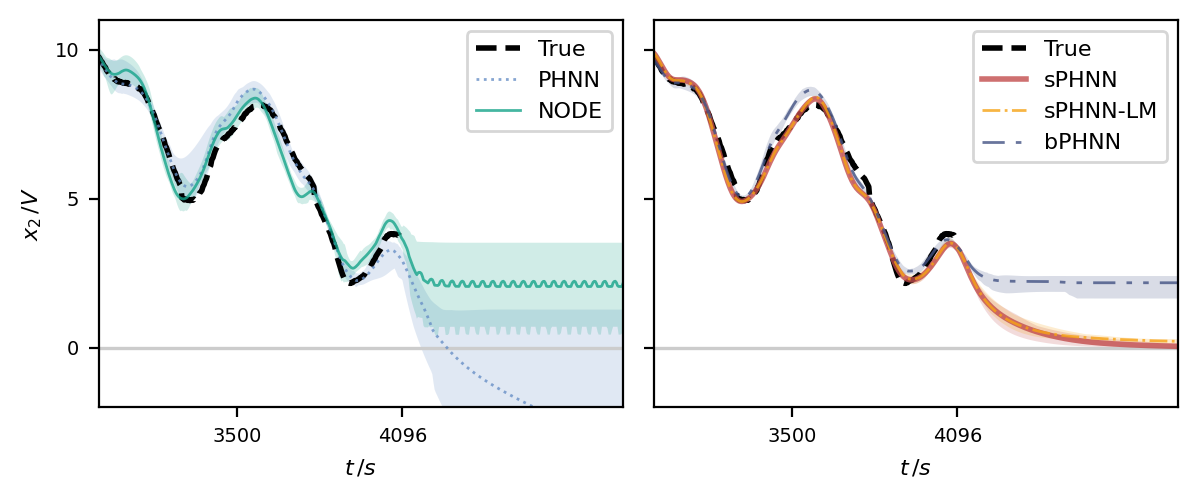

In [10]:
num_models = len(prediction_data) - 1
use_line = 'interquartile_mean'
model_in_subplot = {'sPHNN': 1, 'sPHNN-LM': 1, 'cPHNN': 1, 'PHNN': 0, 'NODE': 0}

num_subplots = np.unique(list(model_in_subplot.values())).size
fig, axes = plt.subplots(1, num_subplots, sharey=True, figsize=(3*num_subplots, 2.5), dpi=PLOT_DPI)

for n, ax in enumerate(axes):
    ax.axhline(y = 0, linestyle = '-', c=colors.theme_colors['grey'], lw=1.2) 
    gt_ys_line, = ax.plot(true_data['ts'], true_data['ys'][0,:,0], c='black', ls='--', lw=2, label='True')

    ax.set(
        axisbelow=True,
        # title=f'Test prediction',
        xlabel=R'$t\,/s$',
        ylabel=R'$x_2\,/V$' if n==0 else '',
        ylim=[-2,11],
        yticks=[0, 5, 10],
        xlim=[3000, true_data['ts'].max()],
        xticks=[3500, 4096],
    )

for n, (model_type, metrics) in enumerate(prediction_data.items()):
    ax_idx = model_in_subplot[model_type]
    ax = axes[ax_idx]
    line, = ax.plot(true_data['ts'], metrics['ys'][use_line][0,:,0], 
                    **model_style[model_type],
                    label=model_names[model_type])
    ax.fill_between(true_data['ts'], metrics['ys']['first_quartile'][0,:,0], 
                    metrics['ys']['third_quartile'][0,:,0], 
                    lw=0,
                    alpha=0.2, zorder=1, color=line.get_color(), 
                    )
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Print equilibria of the sPHNN-LM models

In [11]:
minima = [inst['model'].derivative_model.hamiltonian.minimum for inst in results['sPHNN-LM']]
minima = jnp.stack(minima)
best_model_indx = np.argmin([d['test_rmse'] for d in results['sPHNN-LM']])

print(f'Equilibrium location of all sPHNN-LM instances: \n\
      Minimum: {minima[:,0].min():.3f} \n\
      Maximum: {minima[:,0].max():.3f} \n\
      Best instance: {minima[best_model_indx, 0]:.3f}')

Equilibrium location of all sPHNN-LM instances: 
      Minimum: -0.196 
      Maximum: 0.432 
      Best instance: 0.349


#### Saturation experiment

In [12]:
_, ys_eval, _ = test_data # Get the initial conditions
n = 1000
ts_extra = 4. * jnp.arange(n)
ys_extra = np.full((1,n,1), np.nan)
ys_extra[:,0] = ys_eval[:,0]
us_extra = 1 + 0.01 * jnp.arange(n)[None, :, None]

prediction_data, true_data = evaluation.get_prediction_statistics(ts_extra, ys_extra, us_extra, results, exclude_model_types='physical')

# of valid sPHNN predictions: 20
# of valid sPHNN-LM predictions: 20
# of valid cPHNN predictions: 20
# of valid PHNN predictions: 20
# of valid NODE predictions: 20


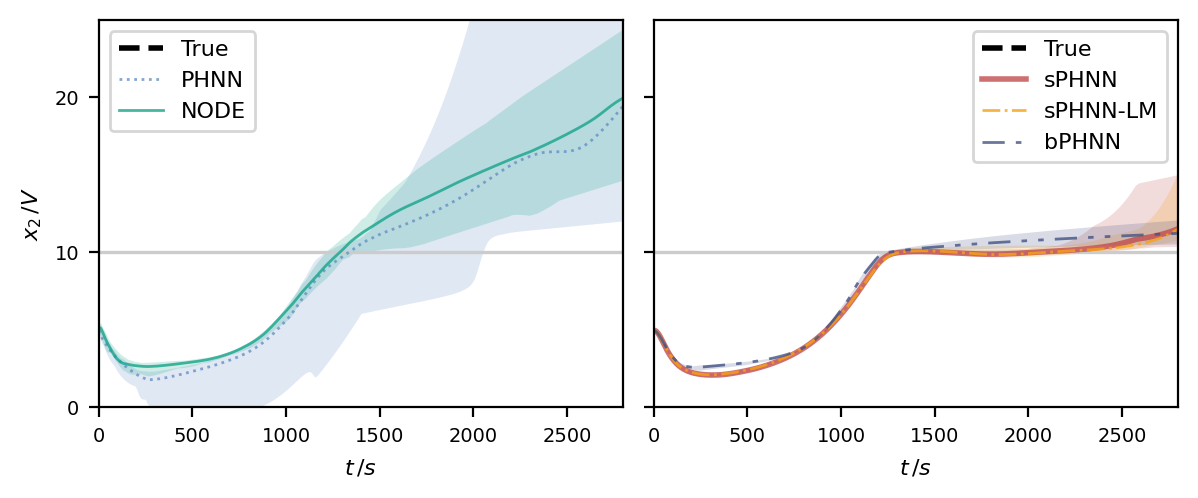

In [13]:
num_models = len(prediction_data) - 1
use_line = 'interquartile_mean'
model_in_subplot = {'sPHNN': 1, 'sPHNN-LM': 1, 'cPHNN':1, 'PHNN': 0, 'NODE': 0}

num_subplots = np.unique(list(model_in_subplot.values())).size
fig, axes = plt.subplots(1, num_subplots, sharey=True, figsize=(3*num_subplots, 2.5), dpi=PLOT_DPI)

for n, ax in enumerate(axes):
    ax.axhline(y = 10, linestyle = '-', c=colors.theme_colors['grey'], lw=1.2) 
    gt_ys_line, = ax.plot(true_data['ts'], true_data['ys'][0,:,0], c='black', ls='--', lw=2, label='True')

    ax.set(
        axisbelow=True,
        # title=f'Test prediction',
        xlabel=R'$t\,/s$',
        ylabel=R'$x_2\,/V$' if n==0 else '',
        ylim=[0,25],
        yticks=[0,10,20],
        xlim=[true_data['ts'].min(), 2800],
    )

for n, (model_type, metrics) in enumerate(prediction_data.items()):
    ax_idx = model_in_subplot[model_type]
    ax = axes[ax_idx]
    line, = ax.plot(true_data['ts'], metrics['ys'][use_line][0,:,0], 
                    **model_style[model_type],
                    label=model_names[model_type])
    ax.fill_between(true_data['ts'], metrics['ys']['first_quartile'][0,:,0], 
                    metrics['ys']['third_quartile'][0,:,0], 
                    lw=0,
                    alpha=0.2, zorder=1, color=line.get_color(), 
                    )
    ax.legend()
plt.tight_layout()
plt.show()